In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Compose, Lambda, Normalize
import matplotlib.pyplot as plt

In [ ]:
training_data = datasets.FashionMNIST(
    root="/content/drive/MyDrive/deep_learning_hws/HWs/2/dataset_HW2_P1", # the root directory to save the downloaded dataset
    train=True, # choose whether it is test or train
    download=True, # choose whether to download the dataset or not 
    transform=Compose([ToTensor(), Lambda(lambda x: (torch.flatten(x)).to(torch.double) )]),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.double).scatter_(0, torch.tensor(y), value=1))
)

test_data = datasets.FashionMNIST(
    root="/content/drive/MyDrive/deep_learning_hws/HWs/2/dataset_HW2_P1",
    train=False,
    download=True,
    transform=Compose([ToTensor(), Lambda(lambda x: torch.flatten(x))]),
    # target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

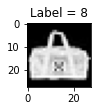

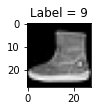

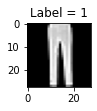

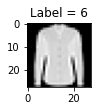

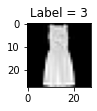

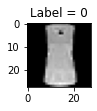

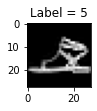

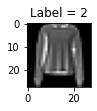

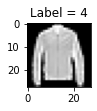

In [43]:
from matplotlib import pyplot
label_list = []
t=0
while(len(label_list)!=9):  
  ind = (random.sample(range(0, len(training_data)), 1))[0]
  label = ((training_data[ind][1]).argmax()).item()
  if not(label in label_list):
    pyplot.subplot(330 + 1 + len(label_list))
    label_list.append(((training_data[ind][1]).argmax()).item())
    plt.title(f"Label = {(training_data[ind][1]).argmax()}")
    pyplot.imshow(training_data[ind][0].reshape((28, 28)), cmap=pyplot.get_cmap('gray'))
    pyplot.show()
  else:
    pass

In [ ]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [ ]:
def MyRelu(X):
  return X.clamp(min=0)

In [ ]:
def Mysoftmax(x): 
    maxes = torch.max(x, 1, keepdim=True)[0]
    x_exp = torch.exp(x-maxes)
    x_exp_sum = torch.sum(x_exp, 1, keepdim=True)
    probs = x_exp/x_exp_sum
    return probs

In [ ]:
def cross_entropy(labels, pred, dim=-1):
  l=0
  for i , j in zip(pred,labels):
    l-=torch.matmul(j, torch.log(i+.1).T)
  return l

In [ ]:
def model(x_b, w1,w2,w3, b1,b2, b3):
    layer_1 = x_b.mm(w1) + b1
    Relu_1 = MyRelu(layer_1)
    layer_2 = Relu_1.mm(w2) + b2
    Relu_2 = MyRelu(layer_2)
    layer_3 = Relu_2.mm(w3) + b3
    y_b = Mysoftmax(layer_3)
    return y_b

In [ ]:
device = 'cpu'

In [ ]:
w1 = torch.nn.init.uniform_(torch.empty((784, 255), device=device, dtype=torch.double, requires_grad=True), a=-.3, b=.3)
b1 = torch.nn.init.uniform_(torch.empty((1, 255), device=device, dtype=torch.double, requires_grad=True), a=-.3, b=.3)
w2 = torch.nn.init.uniform_(torch.empty((255, 255), device=device, dtype=torch.double, requires_grad=True), a=-.3, b=.3)
b2 = torch.nn.init.uniform_(torch.empty((1, 255), device=device, dtype=torch.double, requires_grad=True), a=-.3, b=.3)
w3 = torch.nn.init.uniform_(torch.empty((255, 10), device=device, dtype=torch.double, requires_grad=True), a=-.3, b=.3)
b3 = torch.nn.init.uniform_(torch.empty((1, 10), device=device, dtype=torch.double, requires_grad=True), a=-.3, b=.3)


learning_rate = 1e-3
size = len(train_dataloader.dataset)
for t in range(100):
    for batch, (X_batch, Y_batch) in enumerate(train_dataloader):
        y_pred = model(X_batch,w1,w2,w3,b1,b2,b3)
        loss = cross_entropy(Y_batch,y_pred)
        loss.backward()
        w1_g = w1.grad
        b1_g = b1.grad
        w2_g = w2.grad
        b2_g = b2.grad
        w3_g = w3.grad
        b3_g = b3.grad
        
        w1 = w1.detach()
        w1 -= learning_rate * w1_g
        w1 = w1.requires_grad_()
        b1 = b1.detach()
        b1 -= learning_rate * b1_g
        b1 = b1.requires_grad_()

        w2 = w2.detach()
        w2 -= learning_rate * w2_g
        w2 = w2.requires_grad_()
        b2 = b2.detach()
        b2 -= learning_rate * b2_g
        b2 = b2.requires_grad_()

        w3 = w3.detach()
        w3 -= learning_rate * w3_g
        w3 = w3.requires_grad_()
        b3 = b3.detach()
        b3 -= learning_rate * b3_g
        b3 = b3.requires_grad_()
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X_batch)
            print(f"train_loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        
    test_size = len(test_dataloader.dataset)
    test_num_batches = len(test_dataloader)
    test_loss, test_correct = 0, 0
    with torch.no_grad():
      for X, y in test_dataloader:
          pred = model(X.squeeze().reshape(-1,784).to(torch.double),w1,w2,w3,b1,b2,b3)
          test_correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= test_num_batches
    test_correct /= test_size
    print(f"test_Accuracy: {(100*test_correct):>0.1f}%")

<ipython-input-6-0d989e45f6f3>:4: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3277.)
  l-=torch.matmul(j, torch.log(i+.1).T)


train_loss: 134.644190  [    0/60000]
train_loss: 94.262540  [ 6400/60000]
train_loss: 61.449508  [12800/60000]
train_loss: 65.327688  [19200/60000]
train_loss: 73.707314  [25600/60000]
train_loss: 67.640993  [32000/60000]
train_loss: 58.404300  [38400/60000]
train_loss: 71.121047  [44800/60000]
train_loss: 47.414529  [51200/60000]
train_loss: 39.405786  [57600/60000]
test_Accuracy: 66.6%
train_loss: 29.450334  [    0/60000]
train_loss: 43.689832  [ 6400/60000]
train_loss: 42.951975  [12800/60000]
train_loss: 36.687523  [19200/60000]
train_loss: 38.536547  [25600/60000]
train_loss: 38.994136  [32000/60000]
train_loss: 48.023639  [38400/60000]
train_loss: 24.236419  [44800/60000]
train_loss: 40.835453  [51200/60000]
train_loss: 26.225428  [57600/60000]
test_Accuracy: 73.6%
train_loss: 28.385953  [    0/60000]
train_loss: 31.525629  [ 6400/60000]
train_loss: 22.172686  [12800/60000]
train_loss: 34.987434  [19200/60000]
train_loss: 28.020805  [25600/60000]
train_loss: 24.274028  [32000/60